
# NOTEBOOK 01: DATA EXPLORATION & METADATA COLLECTION

Purpose: Discover MIMIC-III Matched Subset records, extract metadata,
         filter for usable PPG signals (≥10 min duration)

Output:
 - data/metadata/all_records.parquet (full metadata)
  - data/metadata/usable_records.parquet (filtered for processing)

Target: ~3,000 usable PPG records from 200-300 subjects


## Environment Setup

In [ ]:
# Mount Google Drive and setup project structure
# from google.colab import drive
# drive.mount('/content/drive')

# Install dependencies (silent mode)
!pip install pandas==2.2.2 wfdb==4.1.2 mlflow pywavelets hydra-core pyarrow fastparquet neurokit2 comorbidipy requests -q

import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime

# Set project root
PROJECT_ROOT = Path('/content/drive/MyDrive/cardiometabolic-risk-colab')
os.chdir(PROJECT_ROOT)
sys.path.insert(0, str(PROJECT_ROOT / 'colab_src'))

print(f"✅ Environment ready")
print(f"   Working directory: {PROJECT_ROOT}")
print(f"   Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Environment ready
   Working directory: /content/drive/MyDrive/cardiometabolic-risk-colab
   Timestamp: 2026-01-04 21:11:54


## Import Modules

In [2]:
# Import custom modules
from data_pipeline import MIMICDataIngestor
from utils import ExperimentTracker

# Initialize components
ingestor = MIMICDataIngestor()
tracker = ExperimentTracker()
run = tracker.start_run("data_exploration")

print("✅ Modules loaded")

✅ Modules loaded


/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


## Test Connection

In [3]:
# Verify PhysioNet access before proceeding
connection_ok = ingestor.test_connection()

if not connection_ok:
    print("\n🛑 STOP: Fix connection issues before proceeding")
    print("\nTroubleshooting:")
    print("1. Check internet connection")
    print("2. Verify PhysioNet is accessible: https://physionet.org/")
    print("3. Update WFDB: !pip install --upgrade wfdb")
else:
    print("\n✅ Connection verified - ready to proceed")

🔍 Testing MIMIC-III Matched Subset access...
✅ Found 10282 subjects
✅ Successfully read header
   Signals: None
   Duration: 1315.0 min

✅ Connection verified - ready to proceed


## Discover record files (Small)
starting with 10 subjects

In [4]:
# Initial discovery with 10 subjects to validate pipeline
# This creates cache: data/cache/all_record_files.json

print("="*70)
print("PHASE 1: PILOT DISCOVERY (10 subjects)")
print("="*70)

record_files = ingestor.get_all_record_files(limit_subjects=10)

print(f"\n✅ Pilot discovery complete")
print(f"   Total records: {len(record_files)}")
print(f"   Average records/subject: {len(record_files)/10:.1f}")
print(f"\n📋 Sample paths:")
for rec in record_files[:5]:
    print(f"   {rec}")

PHASE 1: PILOT DISCOVERY (10 subjects)
🔍 Step 1: Getting subject directories from main RECORDS...
✅ Found 10282 subject directories
📊 Limited to first 10 subjects

🔍 Step 2: Getting record files from each subject...


Scanning subjects: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


✅ Discovery complete
   Total records found: 1223
   Failed subjects: 0/10
💾 Cached to data/cache/all_record_files.json

✅ Pilot discovery complete
   Total records: 1223
   Average records/subject: 122.3

📋 Sample paths:
   p00/p000020/p000020-2183-04-28-17-47
   p00/p000020/p000020-2183-04-28-17-47n
   p00/p000020/3544749_0001
   p00/p000020/3544749_0002
   p00/p000020/3544749_0003


## Meta data streaming (Pilot Batch)


*   starting with 50 records




In [5]:
# Extract metadata for first 100 records to estimate PPG prevalence
# This creates cache: data/cache/record_metadata.parquet

print("\n" + "="*70)
print("PHASE 2: METADATA EXTRACTION (100 records)")
print("="*70)

metadata_df = ingestor.stream_records_metadata_parallel(
    limit_subjects=10,
    max_workers=8,  # Lower workers
    checkpoint_every=500
)

if len(metadata_df) == 0:
    print("❌ No metadata collected - check errors above")
else:
    print(f"\n✅ Metadata extracted")
    print(f"   Records processed: {len(metadata_df)}")
    print(f"   Columns: {list(metadata_df.columns)}")

    # Show signal availability
    print(f"\n📊 Signal Availability:")
    print(f"   PPG signals: {metadata_df['has_ppg'].sum()} ({metadata_df['has_ppg'].sum()/len(metadata_df)*100:.1f}%)")
    print(f"   ECG signals: {metadata_df['has_ecg'].sum()} ({metadata_df['has_ecg'].sum()/len(metadata_df)*100:.1f}%)")

    # Show duration distribution
    print(f"\n📊 Duration Statistics (minutes):")
    print(f"   Mean: {metadata_df['duration_min'].mean():.1f}")
    print(f"   Median: {metadata_df['duration_min'].median():.1f}")
    print(f"   Min: {metadata_df['duration_min'].min():.1f}")
    print(f"   Max: {metadata_df['duration_min'].max():.1f}")


PHASE 2: METADATA EXTRACTION (100 records)
📦 Loaded 1223 record files from cache

🚀 Starting parallel metadata extraction
   Workers: 8
   Records: 1223
   Rate limit: 20 req/sec (with exponential backoff retry)
   Method: rdheader() [header-only, ~1KB per record]



Extracting metadata: 100%|██████████| 1223/1223 [03:34<00:00,  5.69it/s, rate=5.8 rec/s, failed=0, eta=0.6m]


✅ Metadata extraction complete
   Total time: 3.6 minutes
   Successful: 1193/1223
   Failed: 0
   Rate: 341 records/min

📊 Signal availability:
   PPG: 816 / 1193 records
   ECG: 1117 / 1193 records

✅ Metadata extracted
   Records processed: 1193
   Columns: ['record_name', 'subject_id', 'duration_min', 'duration_sec', 'has_ppg', 'has_ecg', 'sampling_rate', 'n_channels', 'signal_names', 'base_datetime']

📊 Signal Availability:
   PPG signals: 816 (68.4%)
   ECG signals: 1117 (93.6%)

📊 Duration Statistics (minutes):
   Mean: 119.0
   Median: 0.3
   Min: 0.0
   Max: 15694.4


## Display Sample Records

In [6]:
# Visual inspection of metadata
if len(metadata_df) > 0:
    print("\n📋 Sample Records:")
    display(metadata_df[['record_name', 'subject_id', 'duration_min',
                        'has_ppg', 'has_ecg', 'sampling_rate', 'signal_names']].head(5))


📋 Sample Records:


,record_name,subject_id,duration_min,has_ppg,has_ecg,sampling_rate,signal_names
0,p00/p000020/p000020-2183-04-28-17-47,p000020,1315.012400,False,False,125,
1,p00/p000020/3544749_0001,p000020,0.508133,False,True,125,"II,AVF,ABP,PAP"
2,p00/p000020/3544749_0002,p000020,0.016533,False,True,125,"II,AVF,ABP,PAP"
3,p00/p000020/3544749_0003,p000020,0.001067,False,True,125,"II,AVF,ABP,PAP"
4,p00/p000020/3544749_0004,p000020,0.050667,False,True,125,"II,AVF,ABP,PAP"


###My notes on the display of samples:
most duration_minutes are low, below 1 minutes. This may be statistically useless for my deep learning or for my HRV since the "warm-up" time for most filters (like the Chebyshev-II) would consume most of the signal. has_ppg are all set to False. trouble shoot this
I've to filter out the first row(Index 0):
for full_path in tqdm(record_files, desc="Reading metadata"):
    # SKIP NUMERICS FILES
    if full_path.endswith('n'):
        continue
        
    try:
        # ... rest of your logic

## Filter Usable Records (Pilot)

In [7]:
# Apply filters: PPG present + duration ≥10 minutes
usable_pilot = ingestor.filter_usable_records(metadata_df, min_duration_min=10)

if len(usable_pilot) > 0:
    # Calculate expected yield for full dataset
    usable_rate = len(usable_pilot) / len(metadata_df)

    print(f"\n📊 Pilot Results:")
    print(f"   Usable rate: {usable_rate*100:.1f}%")
    print(f"   Usable records: {len(usable_pilot)}/{len(metadata_df)}")

    # Estimate full dataset yield
    total_records = len(record_files)
    estimated_usable = int(total_records * usable_rate)

    print(f"\n🎯 Projected Yield (from {len(record_files)} records):")
    print(f"   Expected usable: ~{estimated_usable} records")

    # Calculate subjects needed for target
    TARGET_RECORDS = 3000
    records_per_subject = len(record_files) / 10  # From 10 subjects
    usable_per_subject = records_per_subject * usable_rate
    subjects_needed = int(TARGET_RECORDS / usable_per_subject)

    print(f"\n🎯 To reach {TARGET_RECORDS} usable records:")
    print(f"   Need ~{subjects_needed} subjects")
    print(f"   (Assuming {usable_per_subject:.1f} usable records/subject)")
else:
    print("\n⚠️  No usable records found - check filtering criteria")


✅ Filtered: 265/1193 usable records

📊 Duration: Mean=194.1 min
📊 Sampling rates:
sampling_rate
125    265
Name: count, dtype: int64

📊 Pilot Results:
   Usable rate: 22.2%
   Usable records: 265/1193

🎯 Projected Yield (from 1223 records):
   Expected usable: ~271 records

🎯 To reach 3000 usable records:
   Need ~110 subjects
   (Assuming 27.2 usable records/subject)


## Clear Cache for scale up

In [8]:
# Clear caches before scaling to full dataset
import os

cache_files = [
    'data/cache/record_metadata.parquet',
    'data/cache/all_record_files.json'
]

print("🧹 Clearing pilot caches for full-scale discovery...")
for cache_file in cache_files:
    if Path(cache_file).exists():
        os.remove(cache_file)
        print(f"   ✅ Cleared: {cache_file}")

print("\n✅ Ready for full-scale processing")

🧹 Clearing pilot caches for full-scale discovery...
   ✅ Cleared: data/cache/record_metadata.parquet
   ✅ Cleared: data/cache/all_record_files.json

✅ Ready for full-scale processing


### Scanning broadly to find ppg

In [9]:
# # EMERGENCY: Scale up aggressively to find PPG signals
# print("="*70)
# print("EMERGENCY SCALE-UP: Finding PPG Signals")
# print("="*70)

# # Start with 100 subjects (10% of database)
# SCALE_SUBJECTS = 20

# print(f"Target: Find subjects with PPG signals")
# print(f"Scanning: {SCALE_SUBJECTS} subjects")
# print(f"⏱️  Estimated time: {SCALE_SUBJECTS * 0.3:.1f} minutes")
# print("="*70)

# record_files_full = ingestor.get_all_record_files(limit_subjects=SCALE_SUBJECTS)

# print(f"\n✅ Discovery complete: {len(record_files_full)} records")

In [9]:
#  diagnostic
print("Checking PPG detection...")
print("\nRecords containing 'PLETH' in signal_names:")
pleth_records = metadata_df[metadata_df['signal_names'].str.contains('PLETH', na=False)]
print(f"Count: {len(pleth_records)}")

print("\nRecords containing 'PPG' in signal_names:")
ppg_records = metadata_df[metadata_df['signal_names'].str.contains('PPG', na=False)]
print(f"Count: {len(ppg_records)}")

print("\nAll unique signal name patterns:")
print(metadata_df['signal_names'].unique()[:20])

Checking PPG detection...

Records containing 'PLETH' in signal_names:
Count: 816

Records containing 'PPG' in signal_names:
Count: 0

All unique signal name patterns:
['' 'II,AVF,ABP,PAP' 'II,AVF' 'II,V' 'II,MCL1' 'RESP,PLETH,II'
 'RESP,PLETH,II,V,AVR' 'II,AVF,ABP' 'RESP,PLETH,III,V,II'
 'RESP,II,V,AVR,PLETH' 'RESP,II,V,AVR' 'RESP,III,V,II' 'PLETH,II,V,AVR'
 'II,ABP,PAP' 'II' 'II,PAP' 'II,ABP' 'II,MCL1,ABP,PAP' 'II,V,ABP,PAP'
 'II,MCL1,PAP']


## Full Scale Discovery

In [10]:


# Calculate optimal subject count from pilot
if len(usable_pilot) > 0:
    TARGET_RECORDS = 3000
    SCALE_SUBJECTS = min(TARGET_RECORDS, 600)  # Cap at 600 for safety

    print("="*70)
    print(f"PHASE 3: FULL-SCALE DISCOVERY ({SCALE_SUBJECTS} subjects)")
    print("="*70)
    print(f"Target: {TARGET_RECORDS} usable records")
    print(f"Scanning: {SCALE_SUBJECTS} subjects")
    print(f"\n⏱️  Estimated time: {SCALE_SUBJECTS * 0.3:.1f} minutes")
    print("="*70)

    # Discover all record files
    record_files_full = ingestor.get_all_record_files(limit_subjects=SCALE_SUBJECTS)

    print(f"\n✅ Full discovery complete")
    print(f"   Total records found: {len(record_files_full)}")
    print(f"   Subjects scanned: {SCALE_SUBJECTS}")
else:
    print("⚠️  Run pilot cells first to calculate optimal scale")

PHASE 3: FULL-SCALE DISCOVERY (600 subjects)
Target: 3000 usable records
Scanning: 600 subjects

⏱️  Estimated time: 180.0 minutes
🔍 Step 1: Getting subject directories from main RECORDS...
✅ Found 10282 subject directories
📊 Limited to first 600 subjects

🔍 Step 2: Getting record files from each subject...


Scanning subjects: 100%|██████████| 600/600 [03:39<00:00,  2.74it/s]


✅ Discovery complete
   Total records found: 38411
   Failed subjects: 0/600
💾 Cached to data/cache/all_record_files.json

✅ Full discovery complete
   Total records found: 38411
   Subjects scanned: 600


## Extract Meta Data (Full Data)

In [11]:
# PHASE 4: OPTIMIZED METADATA EXTRACTION
if 'record_files_full' in locals() and len(record_files_full) > 0:
    print("\n" + "="*70)
    print("PHASE 4: OPTIMIZED METADATA EXTRACTION")
    print("="*70)

    # Use new optimized method
    metadata_full = ingestor.stream_records_metadata_parallel(
        limit_subjects=SCALE_SUBJECTS,
        max_workers=16,  # Adjust based on network/CPU
        checkpoint_every=1000
    )

    if len(metadata_full) > 0:
        metadata_full.to_parquet('data/metadata/all_records.parquet', index=False)

        print(f"\n✅ Metadata saved: {len(metadata_full)} records")
        print(f"   PPG rate: {metadata_full['has_ppg'].sum() / len(metadata_full):.1%}")

        tracker.log_params({
            'n_subjects': SCALE_SUBJECTS,
            'n_records_processed': len(metadata_full),
            'method': 'rdheader_parallel'
        })


PHASE 4: OPTIMIZED METADATA EXTRACTION
📦 Loaded 38411 record files from cache

🚀 Starting parallel metadata extraction
   Workers: 16
   Records: 38411
   Rate limit: 20 req/sec (with exponential backoff retry)
   Method: rdheader() [header-only, ~1KB per record]



Extracting metadata: 100%|██████████| 38411/38411 [1:23:25<00:00,  7.67it/s, rate=7.7 rec/s, failed=0, eta=0.9m]



✅ Metadata extraction complete
   Total time: 83.5 minutes
   Successful: 37195/38411
   Failed: 0
   Rate: 460 records/min

📊 Signal availability:
   PPG: 9076 / 37195 records
   ECG: 26986 / 37195 records

✅ Metadata saved: 37195 records
   PPG rate: 24.4%


### Enhanced filtering

In [12]:
# ENHANCED FILTERING: More stringent criteria
print("\n" + "="*70)
print("ENHANCED FILTERING")
print("="*70)

# Apply multiple filters
usable_records = metadata_full[
    (metadata_full['has_ppg'] == True) &           # Must have PPG
    (metadata_full['duration_min'] >= 10) &        # At least 10 minutes (stricter)
    (metadata_full['sampling_rate'] == 125)        # Standard sampling rate
].copy()

print(f"\nFiltering criteria:")
print(f"   ✓ PPG signal present")
print(f"   ✓ Duration ≥ 10 minutes")
print(f"   ✓ Sampling rate = 125 Hz")

print(f"\nResults:")
print(f"   Usable records: {len(usable_records)}")
print(f"   Mean duration: {usable_records['duration_min'].mean():.1f} min")

if len(usable_records) < 100:
    print(f"\n⚠️  WARNING: Only {len(usable_records)} usable records")
    print(f"   → Need to scale to 200-500 subjects")


ENHANCED FILTERING

Filtering criteria:
   ✓ PPG signal present
   ✓ Duration ≥ 10 minutes
   ✓ Sampling rate = 125 Hz

Results:
   Usable records: 3225
   Mean duration: 322.8 min


## Filter Usable Records (Full Dataset)

In [13]:
# Apply quality filters to full dataset
if 'metadata_full' in locals() and len(metadata_full) > 0:

    print("\n" + "="*70)
    print("PHASE 5: FILTERING USABLE RECORDS")
    print("="*70)

    usable_records = ingestor.filter_usable_records(
        metadata_full,
        min_duration_min=10
    )

    if len(usable_records) > 0:
        # Save usable records
        usable_records.to_parquet('data/metadata/usable_records.parquet', index=False)

        print(f"\n💾 Saved usable records")
        print(f"   Output: data/metadata/usable_records.parquet")
        print(f"   Records: {len(usable_records)}")

        # Show subject distribution
        subject_counts = usable_records['subject_id'].value_counts()
        print(f"\n📊 Subject Distribution:")
        print(f"   Unique subjects: {len(subject_counts)}")
        print(f"   Records/subject: {len(usable_records)/len(subject_counts):.1f} avg")
        print(f"   Top subject: {subject_counts.iloc[0]} records")

        # Show sampling rate distribution
        print(f"\n📊 Sampling Rates:")
        print(usable_records['sampling_rate'].value_counts())

        # Log to MLflow
        tracker.log_metrics({
            'n_usable_records': len(usable_records),
            'n_unique_subjects': len(subject_counts),
            'usable_rate': len(usable_records) / len(metadata_full)
        })
    else:
        print("\n⚠️  No usable records after filtering")
        print("   Consider relaxing criteria (e.g., min_duration_min=5)")
else:
    print("⚠️  Extract full metadata first (Cell 10)")


PHASE 5: FILTERING USABLE RECORDS

✅ Filtered: 3225/37195 usable records

📊 Duration: Mean=322.8 min
📊 Sampling rates:
sampling_rate
125    3225
Name: count, dtype: int64

💾 Saved usable records
   Output: data/metadata/usable_records.parquet
   Records: 3225

📊 Subject Distribution:
   Unique subjects: 175
   Records/subject: 18.4 avg
   Top subject: 161 records

📊 Sampling Rates:
sampling_rate
125    3225
Name: count, dtype: int64


## Quality Statistics and Visualization


FINAL STATISTICS

📊 Duration Distribution (minutes):
   count   :   3225.0
   mean    :    322.8
   std     :    440.1
   min     :     10.1
   25%     :     57.5
   50%     :    166.7
   75%     :    405.1
   max     :   4592.1

📊 Available Signal Types:
   Records with PLETH: 3225


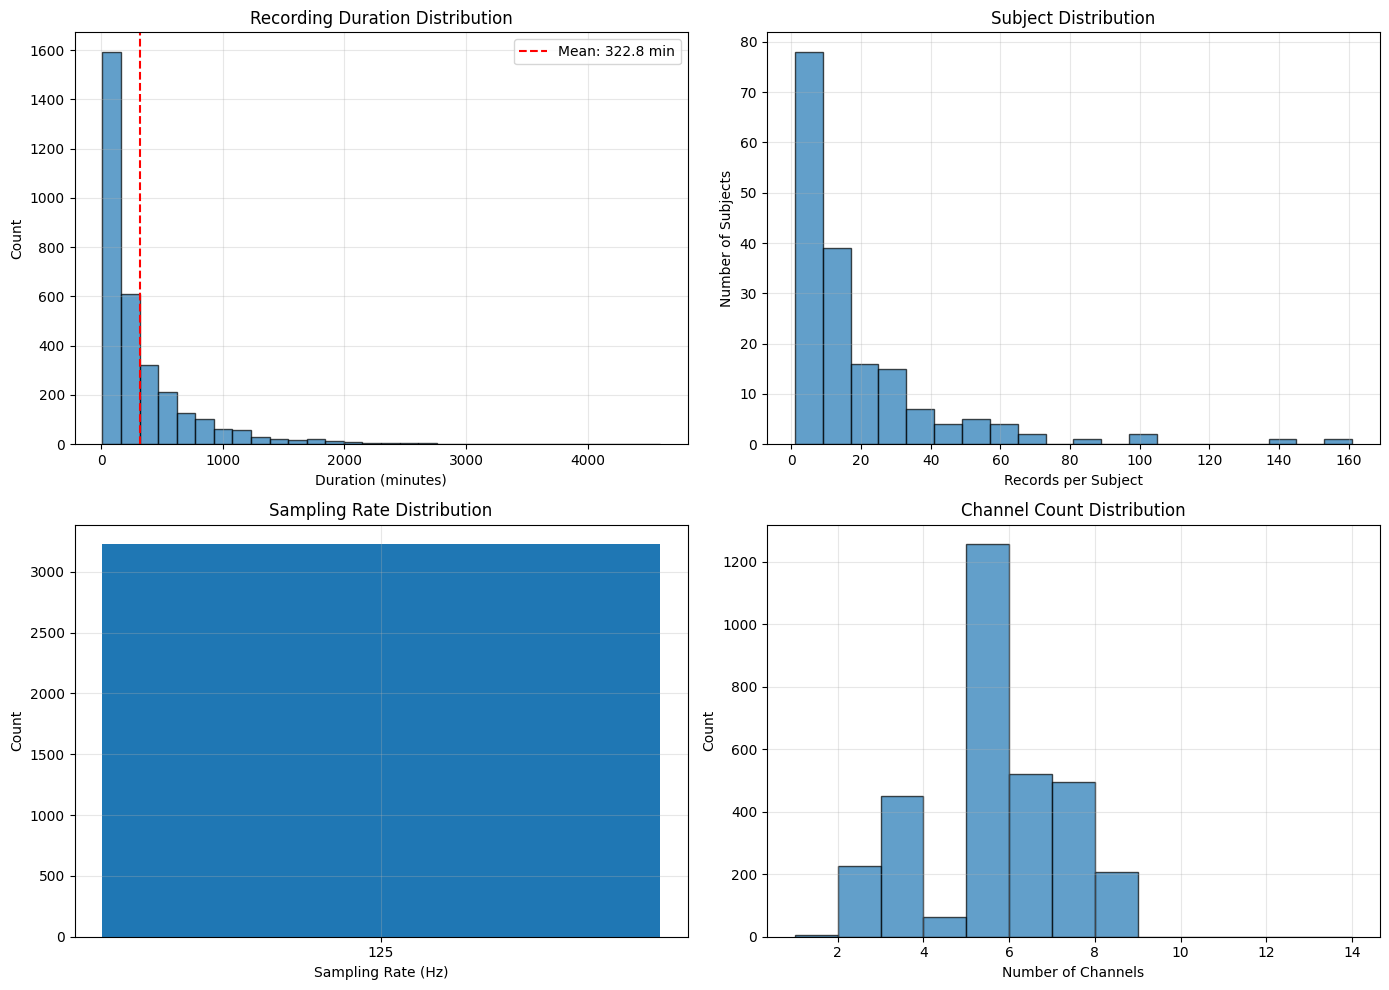


💾 Saved visualization: data/metadata/data_exploration_summary.png


In [14]:
# Generate summary statistics
if 'usable_records' in locals() and len(usable_records) > 0:

    print("\n" + "="*70)
    print("FINAL STATISTICS")
    print("="*70)

    # Duration statistics
    print("\n📊 Duration Distribution (minutes):")
    duration_stats = usable_records['duration_min'].describe()
    for stat, value in duration_stats.items():
        print(f"   {stat:8s}: {value:8.1f}")

    # Signal type distribution
    print(f"\n📊 Available Signal Types:")
    signal_types = usable_records['signal_names'].str.contains('PLETH').sum()
    print(f"   Records with PLETH: {signal_types}")

    # Create visualization
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Duration histogram
    axes[0, 0].hist(usable_records['duration_min'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(usable_records['duration_min'].mean(), color='red',
                      linestyle='--', label=f"Mean: {usable_records['duration_min'].mean():.1f} min")
    axes[0, 0].set_xlabel('Duration (minutes)')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Recording Duration Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # Records per subject
    subject_counts = usable_records['subject_id'].value_counts()
    axes[0, 1].hist(subject_counts.values, bins=20, edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Records per Subject')
    axes[0, 1].set_ylabel('Number of Subjects')
    axes[0, 1].set_title('Subject Distribution')
    axes[0, 1].grid(alpha=0.3)

    # Sampling rate
    sr_counts = usable_records['sampling_rate'].value_counts()
    axes[1, 0].bar(sr_counts.index.astype(str), sr_counts.values)
    axes[1, 0].set_xlabel('Sampling Rate (Hz)')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Sampling Rate Distribution')
    axes[1, 0].grid(alpha=0.3)

    # Channel count
    axes[1, 1].hist(usable_records['n_channels'], bins=range(1, 15),
                   edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Number of Channels')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Channel Count Distribution')
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('data/metadata/data_exploration_summary.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Log artifact
    tracker.log_artifact('data/metadata/data_exploration_summary.png')

    print("\n💾 Saved visualization: data/metadata/data_exploration_summary.png")

## Sample Record Inspection

In [15]:
# Download and inspect 3 sample records to verify data quality
if 'usable_records' in locals() and len(usable_records) > 0:

    print("\n" + "="*70)
    print("SAMPLE RECORD INSPECTION")
    print("="*70)

    # Select 3 diverse samples (short, medium, long duration)
    sorted_by_duration = usable_records.sort_values('duration_min')
    sample_indices = [0, len(sorted_by_duration)//2, len(sorted_by_duration)-1]
    sample_records = sorted_by_duration.iloc[sample_indices]['record_name'].tolist()

    print(f"\nDownloading 3 sample records...")

    for i, rec in enumerate(sample_records, 1):
        print(f"\n[{i}/3] {rec}")
        signal_data = ingestor.download_signal(rec)

        if signal_data:
            duration_min = len(signal_data['signal']) / signal_data['fs'] / 60
            print(f"   ✅ Success")
            print(f"      Samples: {len(signal_data['signal']):,}")
            print(f"      Sampling rate: {signal_data['fs']} Hz")
            print(f"      Duration: {duration_min:.1f} min")
            print(f"      Channel: {signal_data['channel_name']}")
            print(f"      Units: {signal_data['units']}")
            print(f"      Signal range: [{signal_data['signal'].min():.2f}, {signal_data['signal'].max():.2f}]")
        else:
            print(f"   ❌ Failed to download")


SAMPLE RECORD INSPECTION


[1/3] p00/p004053/3831833_0015
   ✅ Success
      Samples: 75,375
      Sampling rate: 125 Hz
      Duration: 10.1 min
      Channel: PLETH
      Units: NU
      Signal range: [0.00, 1.00]

[2/3] p00/p000948/3767856_0008
   ✅ Success
      Samples: 1,250,500
      Sampling rate: 125 Hz
      Duration: 166.7 min
      Channel: PLETH
      Units: NU
      Signal range: [0.00, 4.00]

[3/3] p00/p004679/3940810_0050
   ✅ Success
      Samples: 34,440,500
      Sampling rate: 125 Hz
      Duration: 4592.1 min
      Channel: PLETH
      Units: NU
      Signal range: [nan, nan]


## Summary Report

In [16]:
# Generate final summary report
if 'usable_records' in locals() and len(usable_records) > 0:

    print("\n" + "="*70)
    print("DATA EXPLORATION SUMMARY REPORT")
    print("="*70)

    print(f"\n📅 Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    print(f"\n📊 DISCOVERY RESULTS:")
    print(f"   Subjects scanned: {SCALE_SUBJECTS}")
    print(f"   Total records found: {len(record_files_full)}")
    print(f"   Records with metadata: {len(metadata_full)}")
    print(f"   Usable records (PPG + ≥10 min): {len(usable_records)}")
    print(f"   Usable rate: {len(usable_records)/len(metadata_full)*100:.1f}%")

    print(f"\n📊 DATASET CHARACTERISTICS:")
    print(f"   Unique subjects: {usable_records['subject_id'].nunique()}")
    print(f"   Records per subject: {len(usable_records)/usable_records['subject_id'].nunique():.1f} avg")
    print(f"   Total signal duration: {usable_records['duration_min'].sum()/60:.1f} hours")
    print(f"   Mean record duration: {usable_records['duration_min'].mean():.1f} min")
    print(f"   Sampling rate: {usable_records['sampling_rate'].mode()[0]} Hz (most common)")

    print(f"\n💾 OUTPUT FILES:")
    print(f"   ✅ data/metadata/all_records.parquet ({len(metadata_full)} records)")
    print(f"   ✅ data/metadata/usable_records.parquet ({len(usable_records)} records)")
    print(f"   ✅ data/metadata/data_exploration_summary.png")
    print(f"   ✅ data/cache/all_record_files.json (cached)")

    print(f"\n🎯 NEXT STEPS:")
    if len(usable_records) >= 3000:
        print(f"   ✅ Target achieved ({len(usable_records)} ≥ 3000 records)")
        print(f"   → Proceed to Notebook 02: Signal Quality Analysis")
    else:
        needed = 3000 - len(usable_records)
        print(f"   ⚠️  Need {needed} more records to reach target (3000)")
        additional_subjects = int(needed / (len(usable_records)/SCALE_SUBJECTS))
        print(f"   → Increase SCALE_SUBJECTS to ~{SCALE_SUBJECTS + additional_subjects}")
        print(f"   → Re-run Cell 8-11 with updated scale")

    print("\n" + "="*70)


DATA EXPLORATION SUMMARY REPORT

📅 Timestamp: 2026-01-04 22:55:54

📊 DISCOVERY RESULTS:
   Subjects scanned: 600
   Total records found: 38411
   Records with metadata: 37195
   Usable records (PPG + ≥10 min): 3225
   Usable rate: 8.7%

📊 DATASET CHARACTERISTICS:
   Unique subjects: 175
   Records per subject: 18.4 avg
   Total signal duration: 17352.1 hours
   Mean record duration: 322.8 min
   Sampling rate: 125 Hz (most common)

💾 OUTPUT FILES:
   ✅ data/metadata/all_records.parquet (37195 records)
   ✅ data/metadata/usable_records.parquet (3225 records)
   ✅ data/metadata/data_exploration_summary.png
   ✅ data/cache/all_record_files.json (cached)

🎯 NEXT STEPS:
   ✅ Target achieved (3225 ≥ 3000 records)
   → Proceed to Notebook 02: Signal Quality Analysis



## End MLflow Run

In [17]:
# End MLflow Run
tracker.end_run()
print("\n✅ Data exploration complete")
print("   MLflow logs saved to: logs/mlruns/")


✅ Data exploration complete
   MLflow logs saved to: logs/mlruns/
